Get imports and initialize matplotlib...

In [1]:
from collections import OrderedDict
import numpy as np
import tensorflow as tf
import math
import os

%pylab inline

Populating the interactive namespace from numpy and matplotlib


Get metadata from csv file...

In [2]:
ps = 16 # num of perspectives
zs = 17 # num of outputs zones

ids = []
targets = OrderedDict()
with open('labels.csv') as f:
    header = f.readline()
    for line in f:
        idzone, label = line.split(',')
        sampleid, zone = idzone.split('_')
        zone_number = int(zone[len('Zone'):]) # string looks like "Zone8" so this chops off "Zone"
        zone_number -= 1
        
        if sampleid not in targets:
            ids.append(sampleid)
            targets[sampleid] = np.zeros(zs)
        targets[sampleid][zone_number] = float(label)

random.shuffle(ids) # add randomness to list

Create our (giant...) matrices for training. Takes up roughly 12 GB of system memory (thankfully mine as 32)

Set n to a value to reduce this size for testing

In [3]:
X_train = [] # training data
y_train = [] # training one hot labels
l_train = [] # training labels

w = 512 * ps
h = 660


i = 0
n = 50#len(ids)

for sid in ids:
    path = 'data/{}.aps.npz'.format(sid)

    npzfile = np.load(path)
    data = npzfile['arr_0']
    
    if (np.mean(targets[sid]) == 0):
        continue
    X_train.append(data)
    l_train.append(np.argmax(targets[sid]))
    y_train.append(targets[sid])
    
    i += 1
    print (i, "of", n, end="\r")
    if i >= n:
        break
        
X_train = np.moveaxis(X_train, 3, 1)
y_train = np.moveaxis(y_train, 0, 0) # to convert into a matrix (vs a dictionary?)

X_train = np.reshape(X_train, [n, w, h])
X_train = X_train.astype(np.float32)
print (np.shape(X_train))
print (np.shape(y_train))

(50, 8192, 660)
(50, 17)


In [4]:
# for x in range(max(n, 50)):
#     print (y_train[x], l_train[x])

For some reason the perspective is the last axis in the matrix, move it to be the second matrix so it's more logical (doesn't actually make a difference from a training perspective)

X_train should now be in the form [sampleIndex, perspective, x, y]

Also, moveaxis somehow does this operation while using zero extra memory, no idea how but clearly whoever made it had a better professor for algorithms than Gelfond

Print matrix...

In [5]:
print (X_train[0]) # first sample
print (y_train[0])
print (l_train[0])

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
16


Show Image...

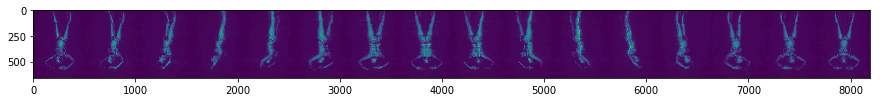

In [6]:
from matplotlib.pyplot import imshow 
figsize(15,4)
im = imshow(np.flipud(X_train[0,:,:]).T, cmap = 'viridis') # 1st sample

make .train() ...

In [7]:


# model hyper parameters
learning_rate = 0.0005

def conv_layer(input_data, num_input_channels, num_filters, filter_shape, name):
    # setup the filter input shape for tf.nn.conv_2d
    conv_filt_shape = [filter_shape[0], filter_shape[1], num_input_channels,
                      num_filters]

    # initialise weights and bias for the filter
    weights = tf.Variable(tf.truncated_normal(conv_filt_shape, stddev=0.03),
                                      name=name+'_W')
    bias = tf.Variable(tf.truncated_normal([num_filters]), name=name+'_b')

    # setup the convolutional layer operation
    out_layer = tf.nn.conv2d(input_data, weights, [1, 1, 1, 1], padding='SAME')

    # add the bias
    out_layer += bias

    # apply a ReLU non-linear activation
    out_layer = tf.nn.relu(out_layer)
    return out_layer
    
def pool(out_layer, pool_shape):
    # now perform max pooling
    ksize = [1, pool_shape[0], pool_shape[1], 1]
    strides = [1, 3, 2, 1]
    out_layer = tf.nn.max_pool(out_layer, ksize=ksize, strides=strides, 
                               padding='VALID')
    return out_layer


x = tf.placeholder(tf.float32, [None, w, h], name="inputx")

x_shaped = tf.reshape(x, [-1, w, h, 1])
# x_shaped = tf.cast(x_shaped, tf.float32)

y = tf.placeholder(tf.float16, [None, zs])

l1 = conv_layer(x_shaped, 1, 3, [3, 3], name='l1')
l2 = conv_layer(l1, 3, 16, [3, 3], name='l2')
l3 = pool(l2, [2,2])
l4 = conv_layer(l3, 16, 16, [3, 3], name='l4')
l5 = conv_layer(l4, 16, 16, [3, 3], name='l5')
l6 = pool(l5, [2,2])
l7 = conv_layer(l6, 16, 32, [3, 3], name='l7')
l8 = conv_layer(l7, 32, 32, [3, 3], name='l8')
l9 = conv_layer(l8, 32, 32, [3, 3], name='l9')
l10 = pool(l9, [2,2])
l11 = conv_layer(l10, 32, 32, [3, 3], name='l11')
l12 = conv_layer(l11, 32, 32, [3, 3], name='l12')
l13 = conv_layer(l12, 32, 32, [3, 3], name='l13')
l14 = pool(l13, [2,2])
l15 = conv_layer(l14, 32, 32, [3, 3], name='l15')
l16 = conv_layer(l15, 32, 32, [3, 3], name='l16')
l17 = conv_layer(l16, 32, 32, [3, 3], name='l17')
l18 = pool(l17, [2,2])




#dilation, seperable filter

dumb = 21760 # use shape_check to get this

flattened = tf.reshape(l18, [-1, dumb])

wd1 = tf.Variable(tf.truncated_normal([dumb, 1024], stddev=0.1), name='wd1')
bd1 = tf.Variable(tf.truncated_normal([1024], stddev=0.01), name='bd1')
dense_layer1 = tf.matmul(flattened, wd1) + bd1
dense_layer1 = tf.nn.relu(dense_layer1)

wd2 = tf.Variable(tf.truncated_normal([1024, 1024], stddev=0.1), name='wd2')
bd2 = tf.Variable(tf.truncated_normal([1024], stddev=0.01), name='bd2')
dense_layer2 = tf.matmul(dense_layer1, wd2) + bd2
dense_layer2 = tf.nn.relu(dense_layer2)

wd3 = tf.Variable(tf.truncated_normal([1024, zs], stddev=0.1), name='wd3')
bd3 = tf.Variable(tf.truncated_normal([zs], stddev=0.01), name='bd3')
dense_layer3 = tf.matmul(dense_layer2, wd3) + bd3
dense_layer3 = tf.nn.relu(dense_layer3)

y_ = tf.nn.softmax(dense_layer3)



cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=dense_layer3, labels=y)

# z_weights = tf.constant([10000, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], tf.float32)

# weighted_cross_entropy = tf.multiply(cross_entropy, z_weights)

weighted_cross_entropy = tf.exp(tf.div(tf.constant(1.), tf.subtract(tf.constant(1.), cross_entropy)))

cost = tf.reduce_mean(weighted_cross_entropy)


# add an optimiser
optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# define an accuracy assessment operation
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float16))


# with tf.Session() as sess:
#     # initialise the variables
#     sess.run(init_op)
#     total_batch = int(len(y_train) / batch_size)
#     for epoch in range(epochs):
#         avg_cost = 0
#         for i in range(total_batch):
#             batch_x, batch_y = X_train[0][(total_batch*epoch+i):min(len(y_train),(total_batch*(epoch+1)))]
#             _, c = sess.run([optimiser, cross_entropy], 
#                             feed_dict={x: batch_x, y: batch_y})
#             avg_cost += c / total_batch
#         test_acc = sess.run(accuracy, 
#                        feed_dict={x: mnist.test.images, y: mnist.test.labels})
#         print("Epoch:", (epoch + 1), "cost =", "{:.3f}".format(avg_cost), " 
#                  test accuracy: {:.3f}".format(test_acc))

#     print("\nTraining complete!")
#     print(sess.run(accuracy, feed_dict={x: mnist.test.images, y: mnist.test.labels}))

shape_check = tf.shape(l18)

In [ ]:
# with tf.Session() as sess:
#     # initialise the variables
#     init_op = tf.global_variables_initializer()
#     sess.run(init_op)
    
#     print(sess.run(shape_check, feed_dict={x: X_train[0:1]}))

run .train() ...

In [ ]:

# Training Hyper Params
epochs           = 100000 # num of cycles to run batches for, checkpoint after each
save_every       = 1      # num cycles between saves
steps_per_batch  = 20     # num of steps to run per batch (low because we don't want too much learning on any one set of images at a time)
batch_size       = 3      # num samples to train per batch (this seems to be the max the card can handle at at time?)
test_percent     = .10

model_name = "VGG_12-10" # model to save into

restore_from = "VGG_12-08-test"
checkpoint_num = "1000" # **** If not valid, will wipe old model!!!



saver = tf.train.Saver()
# setup the initialisation operator
init_op = tf.global_variables_initializer()

test_size = int(n*test_percent)
n -= test_size

path = "D:\\ML\\chkpts\\"

# config = tf.ConfigProto(
#         device_count = {'CPU': 0}
#     )

with tf.Session() as sess:
    
    if os.path.exists(path+restore_from) and os.path.exists(path+restore_from+"\\checkpoint_"+checkpoint_num+".ckpt.meta"):
        saver.restore(sess, path+restore_from+"\\checkpoint_"+checkpoint_num+".ckpt")
        print("restored old model: ",restore_from)
    else:
        if not os.path.exists(path+model_name):
            os.makedirs(path+model_name)
        print("old model not found, starting a new model: ",model_name)
        sess.run(init_op)
    
    
    batches = math.ceil((n) / batch_size)
    
    
    for epoch in range(epochs):
        print ("running epoch",epoch+1,"of",epochs)
        avg_cost = 0
        for i in range(batches):
            s = i * batch_size # start
            e = min((i+1) * batch_size, n)
            x_to_run = X_train[s:e]
            y_to_run = y_train[s:e]
            for j in range(steps_per_batch):
                _, c = sess.run([optimiser, cost], 
                                 feed_dict={x: x_to_run, y: y_to_run})
                avg_cost += c / (steps_per_batch*batches)
            print("ran batch ",i+1,"of",batches, end='\r')
        print("\rEnd Epoch",(epoch+1),"                                  \ncost =", "{:.3f}".format(avg_cost))
        
        test_batches = math.ceil(test_size / batch_size)
    
        correct_preds = 0
        for i in range(test_batches):
            s = i * batch_size + n # start
            e = min((i+1) * batch_size, test_size) + n
            x_to_run = X_train[s:e]
            y_to_run = y_train[s:e]
            test_acc = sess.run(accuracy, feed_dict={x: x_to_run, y: y_to_run})
            correct_preds += int(round(test_acc * (e - s)))
            print("Ran Test Batch ",i," out of ",test_batches," got ",correct_preds," so far", end="\r")
        
        print("Overall Test Accuracy after last epoch: ",correct_preds," out of ",test_size,"                  ")

        if epoch % save_every == 0:
            checkpt = int(epoch/save_every)
            print("Saving Checkpoint:",checkpt)
            saver.save(sess, path+model_name+"\\checkpoint_"+str(checkpt)+".ckpt")
        print("=================================");

    print("\nTraining complete!")
    print(sess.run(accuracy, feed_dict={x: X_test, y: y_test}))

old model not found, starting a new model:  VGG_12-10
running epoch 1 of 100000
End Epoch 1                                   
cost = 0.863
Overall Test Accuracy after last epoch:  2  out of  5                   
Saving Checkpoint: 0
running epoch 2 of 100000
End Epoch 2                                   
cost = 0.787
Overall Test Accuracy after last epoch:  2  out of  5                   
Saving Checkpoint: 1
running epoch 3 of 100000
End Epoch 3                                   
cost = 0.787
Overall Test Accuracy after last epoch:  2  out of  5                   
Saving Checkpoint: 2
running epoch 4 of 100000
End Epoch 4                                   
cost = 0.787
Overall Test Accuracy after last epoch:  2  out of  5                   
Saving Checkpoint: 3
running epoch 5 of 100000
End Epoch 5                                   
cost = 0.787
Overall Test Accuracy after last epoch:  2  out of  5                   
Saving Checkpoint: 4
running epoch 6 of 100000
End Epoch 6         

In [ ]:

# configconfig = tf.ConfigProto()
# configconfig.log_device_placement = True
# configconfig.gpu_options.allow_growth = True

# config = tf.contrib.learn.RunConfig(session_config = configconfig)

